In [1]:
import os
import pyspark
conf = pyspark.SparkConf()
conf.set('spark.ui.proxyBase', '/user/' + os.environ['JUPYTERHUB_USER'] + '/proxy/4041')
# conf.set('spark.sql.repl.eagerEval.enabled', True)
conf.set('spark.driver.memory','64g')

sc = pyspark.SparkContext(conf=conf)
spark = pyspark.SQLContext.getOrCreate(sc)

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/05/07 21:26:19 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
24/05/07 21:26:23 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.
/opt/conda/envs/bigdata/lib/python3.10/site-packages/pyspark/sql/context.py:158: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


In [2]:
df_reviews = spark\
    .read\
    .format("json")\
    .load("Amazon_Fashion.jsonl")\
    .repartition(20)
df_reviews.rdd.getNumPartitions()
df_reviews.count()

2500939

In [3]:
df_reviews = df_reviews.dropDuplicates(['asin', 'user_id', 'timestamp', 'text'])
df_reviews.count()

2475694

In [4]:
# remove duplicate reviews due to user_id suffix
from pyspark.sql import SparkSession, Window
from pyspark.sql.functions import col, row_number, expr

# Define the window specification
windowSpec = Window.partitionBy("text", "timestamp").orderBy(expr("user_id LIKE '%\_%'"))

# Use row_number to assign a rank to each row within each group, prioritized by user_id without '_'
ranked_df = df_reviews.withColumn("rank", row_number().over(windowSpec))

# Filter to keep only the rows ranked 1, i.e., top priority row per group
df_reviews = ranked_df.filter(col("rank") == 1).drop("rank")

df_reviews.count()



2475451

In [5]:
# Check for underscore in user_id using the LIKE operator
contains_underscore = df_reviews.filter(col("user_id").like("%\_%"))

# Count the number of such rows
count = contains_underscore.count()

# Output the result
print("Number of rows with underscores in user_id:", count)


Number of rows with underscores in user_id: 849


In [6]:
from pyspark.sql.types import StructType, StructField, StringType, IntegerType, FloatType

# Define the structure for the data frame 
schema = StructType([ 
    StructField('main_category', StringType(), True), 
    StructField('title', StringType(), True), 
    StructField('average_rating', FloatType(), True), 
    StructField('rating_number', IntegerType(), True), 
    StructField('features', StringType(), True), 
    StructField('description', StringType(), True), 
    StructField('price', FloatType(), True), 
    StructField('images', StringType(), True), 
    StructField('videos', StringType(), True), 
    StructField('store', StringType(), True), 
    StructField('categories', StringType(), True), 
    StructField('details', StringType(), True), 
    StructField('parent_asin', StringType(), True), 
    StructField('bought_together', StringType(), True), 
    StructField('subtitle', StringType(), True), 
    StructField('author', StringType(), True)
])

df_meta = spark\
    .read\
    .schema(schema)\
    .json("meta_Amazon_Fashion.jsonl")\
    .repartition(20)
df_meta.rdd.getNumPartitions()
df_meta.count()

826108

In [7]:
df_meta = df_meta.dropDuplicates()
df_meta.count()

826108

In [8]:
df_reviews.limit(2).toPandas()

,asin,helpful_vote,images,parent_asin,rating,text,timestamp,title,user_id,verified_purchase
0,B00CA8W0US,2,"[(IMAGE, https://images-na.ssl-images-amazon.c...",B00CA8W0US,3.0,,1428931382000,Three Stars,AHQQZV7K7BQAMYJJAY7OU7BCOMSQ,True
1,B00GN5IDNC,7,"[(IMAGE, https://images-na.ssl-images-amazon.c...",B00GN5IDNC,1.0,,1430500974000,Damaged and a waste of money.,AGXCYX7BUCCZY4JDBICMNXFSWWLA,True


In [9]:
df_meta.limit(2).toPandas()

,main_category,title,average_rating,rating_number,features,description,price,images,videos,store,categories,details,parent_asin,bought_together,subtitle,author
0,AMAZON FASHION,Long tassel Earrings Dangle Ball Fringe Tassel...,3.4,8,[],[],NaN,"[{""thumb"":""https://m.media-amazon.com/images/I...",[],None,[],"{""Is Discontinued By Manufacturer"":""No"",""Packa...",B0753C27F2,None,None,None
1,AMAZON FASHION,Cacycasa Womens Steampunk Pirate Shirt Renaiss...,5.0,1,"[""Pull On closure""]",[],NaN,"[{""thumb"":""https://m.media-amazon.com/images/I...",[],Cacycasa,[],"{""Product Dimensions"":""13.78 x 11.81 x 0.79 in...",B094V54TQ8,None,None,None


In [10]:
df_reviews.printSchema()

root
 |-- asin: string (nullable = true)
 |-- helpful_vote: long (nullable = true)
 |-- images: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- attachment_type: string (nullable = true)
 |    |    |-- large_image_url: string (nullable = true)
 |    |    |-- medium_image_url: string (nullable = true)
 |    |    |-- small_image_url: string (nullable = true)
 |-- parent_asin: string (nullable = true)
 |-- rating: double (nullable = true)
 |-- text: string (nullable = true)
 |-- timestamp: long (nullable = true)
 |-- title: string (nullable = true)
 |-- user_id: string (nullable = true)
 |-- verified_purchase: boolean (nullable = true)



In [11]:
df_meta.printSchema()

root
 |-- main_category: string (nullable = true)
 |-- title: string (nullable = true)
 |-- average_rating: float (nullable = true)
 |-- rating_number: integer (nullable = true)
 |-- features: string (nullable = true)
 |-- description: string (nullable = true)
 |-- price: float (nullable = true)
 |-- images: string (nullable = true)
 |-- videos: string (nullable = true)
 |-- store: string (nullable = true)
 |-- categories: string (nullable = true)
 |-- details: string (nullable = true)
 |-- parent_asin: string (nullable = true)
 |-- bought_together: string (nullable = true)
 |-- subtitle: string (nullable = true)
 |-- author: string (nullable = true)



In [12]:
# Filter rows where 'verified_purchase' is False
false_verified = df_reviews.filter(df_reviews['verified_purchase'] == False)
false_verified.count()

161391

In [13]:
verified_df = df_reviews.filter(df_reviews['verified_purchase'] == True)
verified_df.count()

2314060

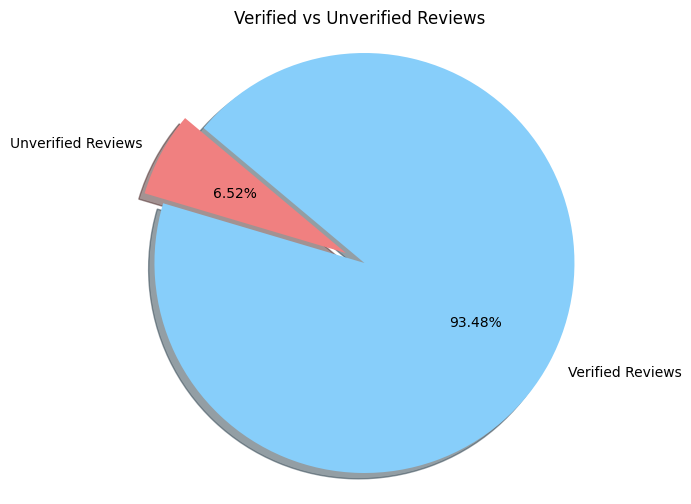

In [14]:
import matplotlib.pyplot as plt

unverified_purchases = false_verified.count()
verified_purchases = verified_df.count()

# Data to plot
labels = 'Unverified Reviews', 'Verified Reviews'
sizes = [unverified_purchases, verified_purchases]
colors = ['lightcoral', 'lightskyblue']
explode = (0.1, 0)

# Plot
plt.figure(figsize=(8, 6))
plt.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.2f%%', shadow=True, startangle=140)
plt.axis('equal')
plt.title('Verified vs Unverified Reviews')

plt.show()


In [15]:
from pyspark.sql.functions import col, count, when

# Count null values in the 'rating' column
null_count = false_verified.select(count(when(col("rating").isNull(), True)).alias("Null Count"))
null_count.show()

+----------+
|Null Count|
+----------+
|         0|
+----------+



In [16]:
# Calculate the count of each rating value
rating_distribution = false_verified.groupBy("rating").count().orderBy("rating")
rating_distribution.show()

+------+-----+
|rating|count|
+------+-----+
|   1.0|18783|
|   2.0|10687|
|   3.0|16729|
|   4.0|27563|
|   5.0|87629|
+------+-----+



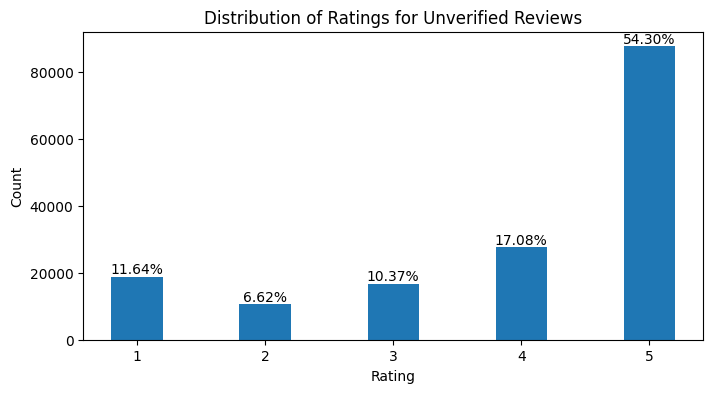

In [17]:
import matplotlib.pyplot as plt

rating_distribution_pd = rating_distribution.toPandas()

# Calculate total number of ratings
total_ratings = rating_distribution_pd['count'].sum()

# Plotting the histogram
plt.figure(figsize=(8, 4))
bars = plt.bar(rating_distribution_pd['rating'], rating_distribution_pd['count'], width=0.4)
plt.xlabel('Rating')
plt.ylabel('Count')
plt.title('Distribution of Ratings for Unverified Reviews')
plt.xticks([1.0, 2.0, 3.0, 4.0, 5.0])

# Adding percentage labels on top of each bar
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, f'{100 * yval / total_ratings:.2f}%', ha='center', va='bottom')

plt.show()

In [18]:
from pyspark.sql.functions import col, count, when

# Count null values in the 'rating' column
null_count2 = verified_df.select(count(when(col("rating").isNull(), True)).alias("Null Count"))
null_count2.show()

+----------+
|Null Count|
+----------+
|         0|
+----------+



In [19]:
# Calculate the count of each rating value
rating_distribution2 = verified_df.groupBy("rating").count().orderBy("rating")
rating_distribution2.show()

+------+-------+
|rating|  count|
+------+-------+
|   1.0| 281249|
|   2.0| 160979|
|   3.0| 226389|
|   4.0| 321318|
|   5.0|1324125|
+------+-------+



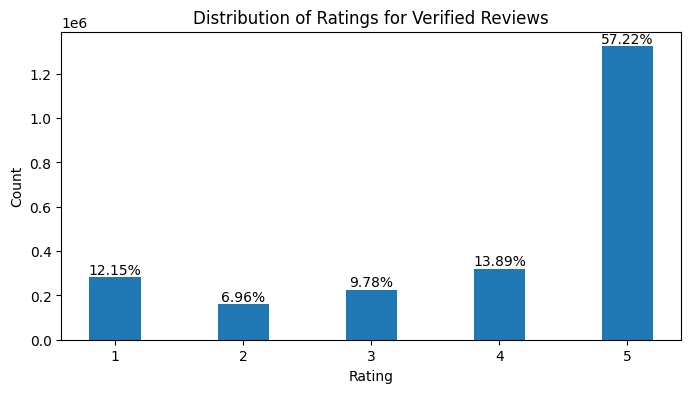

In [20]:
import matplotlib.pyplot as plt

rating_distribution_pd2 = rating_distribution2.toPandas()

# Calculate total number of ratings
total_ratings2 = rating_distribution_pd2['count'].sum()

# Plotting the histogram
plt.figure(figsize=(8, 4))
bars = plt.bar(rating_distribution_pd2['rating'], rating_distribution_pd2['count'], width=0.4)
plt.xlabel('Rating')
plt.ylabel('Count')
plt.title('Distribution of Ratings for Verified Reviews')
plt.xticks([1.0, 2.0, 3.0, 4.0, 5.0])

# Adding percentage labels on top of each bar
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, f'{100 * yval / total_ratings2:.2f}%', ha='center', va='bottom')

plt.show()


In [21]:
from pyspark.sql.functions import col, countDistinct

# Group by 'asin' and 'text', and count each combination
duplicates1 = false_verified.groupBy("asin", "text").agg(count("*").alias("count_reviews")).orderBy(col("count_reviews").desc())

# Check the users and count
check_users1 = false_verified.groupBy("asin", "text").agg(countDistinct("user_id").alias("distinct_users"))

# Natural join duplicates1 and check_users
# joined_df = duplicates1.join(check_users, ["asin", "text"], "inner").orderBy(col("count_reviews").desc())
joined_df1 = duplicates1.join(check_users1, ["asin", "text"], "inner").orderBy(col("count_reviews").desc(), col("distinct_users").desc())

# Show the new DataFrame
joined_df1.limit(30).toPandas()

,asin,text,count_reviews,distinct_users
0,B00AE2WEAI,Love it,2,2
1,B001C9N9OM,Works great!,2,2
2,B00E8767X0,Super cute bracelet!,2,2
3,B00870AEBU,Love it,2,2
4,B00IYF4QSA,nice,2,2
5,B00BPCU23W,Love it,2,2
6,B017CE6758,Good,2,2
7,B00GPIDVAM,love it,2,2
8,B01AHYUMJW,Excellent,2,2
9,B07FRB5VX9,Very cute earrings,2,2


In [22]:
filtered_join1 = joined_df1.where(col("count_reviews") >= 2)
filtered_join1.count()

13

In [23]:
check_duplicates1 = filtered_join1.join(false_verified, ["asin", "text"], "inner").orderBy(col("asin"))
check_duplicates1.limit(30).toPandas()

,asin,text,count_reviews,distinct_users,helpful_vote,images,parent_asin,rating,timestamp,title,user_id,verified_purchase
0,B001C9N9OM,Works great!,2,2,0,[],B001C9N9OM,5.0,1454211680000,Five Stars,AELFACQZMFDNPMLH2QZQWBC23LQA,False
1,B001C9N9OM,Works great!,2,2,0,[],B001C9N9OM,4.0,1441456721000,Four Stars,AF7R3PGUQF4BQYJUA3UCVMRN4AUQ,False
2,B00870AEBU,Love it,2,2,0,[],B0128CHD2A,5.0,1404343379000,Five Stars,AGQGY62RX3PNTHTOFRCWHFPLNJOQ,False
3,B00870AEBU,Love it,2,2,0,[],B0128CHD2A,5.0,1406534104000,Five Stars,AFDQEZGGFQTICS5NS766C2IQV5HA,False
4,B00AE2WEAI,Love it,2,2,0,[],B00AE2WEAI,5.0,1404940405000,Five Stars,AGQDZEFS23JABSDQSDXVZZ3AECMA,False
5,B00AE2WEAI,Love it,2,2,0,[],B00AE2WEAI,5.0,1409078545000,Five Stars,AGLBIUGMCL4SEBSWSJBRCMCDUSHQ,False
6,B00BPCU23W,Love it,2,2,0,[],B00BPCU23W,5.0,1507523998726,Five Stars,AFQ2PA42OY44ND6A6OPUK4VRQ7DQ,False
7,B00BPCU23W,Love it,2,2,0,[],B00BPCU23W,5.0,1406849395000,Five Stars,AGJLPXEJJOVR3GMQWCQQAF3ARFEQ,False
8,B00E8767X0,Super cute bracelet!,2,2,0,[],B00E8767X0,5.0,1410953751000,Adorable!,AFLRXGX335YGA7ZHPB2TEKJLQSLA,False
9,B00E8767X0,Super cute bracelet!,2,2,0,[],B00E8767X0,5.0,1412828462000,Five Stars,AF7B5U7QXMDHT3ZLRG5TXONHDGOQ,False


In [24]:
# Group by 'asin' and 'text', and count each combination
duplicates2 = verified_df.groupBy("asin", "text").agg(count("*").alias("count_reviews")).orderBy(col("count_reviews").desc())

# Check the users and count
check_users2 = verified_df.groupBy("asin", "text").agg(countDistinct("user_id").alias("distinct_users"))

# Natural join duplicates1 and check_users
# joined_df = duplicates1.join(check_users, ["asin", "text"], "inner").orderBy(col("count_reviews").desc())
joined_df2 = duplicates2.join(check_users2, ["asin", "text"], "inner").orderBy(col("count_reviews").desc(), col("distinct_users").desc())

# Show the new DataFrame
joined_df2.limit(35).toPandas()

,asin,text,count_reviews,distinct_users
0,B000GAWSDG,Good,20,20
1,B000FIS5U4,Works great!,19,19
2,B000GAWSDG,Great watch,13,13
3,B000GAWSDG,Excelente,13,13
4,B000FIS5U4,Works great,12,12
5,B000FIS5U4,Great,12,12
6,B000FIS5U4,works great,11,11
7,B000FIS5U4,Works great.,10,10
8,B000GAWSDG,good,10,10
9,B000GAWSDG,Very good,9,9


In [25]:
filtered_join2 = joined_df2.where(col("count_reviews") >= 2)
filtered_join2.count()

2021

In [26]:
filtered_join3 = joined_df2.where(col("count_reviews") > col("distinct_users"))
filtered_join3.count()

0

In [27]:
check_duplicates2 = filtered_join2.join(verified_df, ["asin", "text"], "inner").orderBy(col("asin"), col("text"))
check_duplicates2.limit(20).toPandas()

,asin,text,count_reviews,distinct_users,helpful_vote,images,parent_asin,rating,timestamp,title,user_id,verified_purchase
0,0629150591,Good quality,2,2,0,[],0629150591,5.0,1467593968000,Great quality,AEULS3FAUTUXESFYDDN5ALUL6T6A,True
1,0629150591,Good quality,2,2,0,[],0629150591,4.0,1525758531477,Four Stars,AFBH3VH7WOZP4ZG64HRD4CJKF3FQ,True
2,0629150591,works great,2,2,0,[],0629150591,5.0,1478183351000,Five Stars,AEUZSQ7VH2Q6YLTTALQQQK7QGSWA,True
3,0629150591,works great,2,2,0,[],0629150591,5.0,1472870933000,Five Stars,AGYEFSRF36NCM6DWN3IMJIZ3RWFA,True
4,6152004349,as expected,2,2,0,[],6152004349,5.0,1424196286000,Five Stars,AEGIVKFGJNC6BXHVYVY2BGBU4A6Q,True
5,6152004349,as expected,2,2,0,[],6152004349,4.0,1523819251491,Four Stars,AE3PMT4UN76TH2OCELEHBNYHV6IQ,True
6,B000EB3RXM,good product,2,2,0,[],B000EB3RXM,5.0,1452722155000,great,AF3M2SVX6ETWMNL2SCMBCU36KJKA,True
7,B000EB3RXM,good product,2,2,0,[],B000EB3RXM,5.0,1534632066090,Five Stars,AE3G2QUBDCPRSGEFDHCPE5C3HT2A,True
8,B000FIS5U4,As expected,3,3,0,[],B084RYPGXN,5.0,1475426815000,Five Stars,AFCRCNTDL6EW42OVL525NYITDUUQ,True
9,B000FIS5U4,As expected,3,3,0,[],B084RYPGXN,5.0,1525141624791,Five Stars,AEVPXXKN2CJAPKXPWQYAOMCOVUQA,True


In [28]:
# Sum of helpful votes for unverified reviews
helpful_vote_sum1 = false_verified.selectExpr("sum(helpful_vote) as total_helpful_vote").collect()[0]["total_helpful_vote"]
# Total number of unverified reviews
total_unverified_reviews = false_verified.count()

# Sum of helpful votes for verified reviews
helpful_vote_sum2 = verified_df.selectExpr("sum(helpful_vote) as total_helpful_vote").collect()[0]["total_helpful_vote"]
# Total number of verified reviews
total_verified_reviews = verified_df.count()

# Calculate the percentage of helpful votes out of total unverified reviews
helpful_percent1 = helpful_vote_sum1 / total_unverified_reviews
# Calculate the percentage of helpful votes out of total verified reviews
helpful_percent2 = helpful_vote_sum2 / total_verified_reviews

print("Helpful votes percentage for unverified reviews:", helpful_percent1)
print("Helpful votes percentage for verified reviews:", helpful_percent2)


Helpful votes percentage for unverified reviews: 0.5793507692498343
Helpful votes percentage for verified reviews: 0.5653085918256225


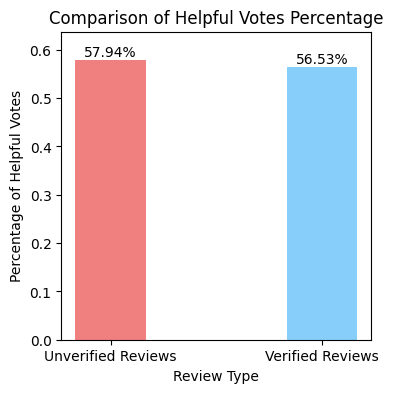

In [29]:
import matplotlib.pyplot as plt

# Data
categories = ['Unverified Reviews', 'Verified Reviews']
values = [helpful_percent1, helpful_percent2]

# Create bar chart
plt.figure(figsize=(4, 4))
bar_positions = [0.4, 1.6]
bars = plt.bar(bar_positions, values, color=['lightcoral', 'lightskyblue'], width=0.4)
plt.xticks(bar_positions, categories)
plt.xlabel('Review Type')
plt.ylabel('Percentage of Helpful Votes')
plt.title('Comparison of Helpful Votes Percentage')
plt.ylim(0, max(values) * 1.1)

# Adding percentage labels on top of each bar
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, f'{yval * 100:.2f}%', ha='center', va='bottom')

plt.show()


In [30]:
# Get distinct ASINs from false_verified
unverified_products = false_verified.select("asin").distinct()
unverified_products.cache()

# Get distinct ASINs from verified_df
verified_products = verified_df.select("asin").distinct()
verified_products.cache()

# Find common ASINs
common_products = unverified_products.intersect(verified_products)

common_products.cache()


DataFrame[asin: string]

In [31]:
# Count distinct ASINs in each DataFrame
unverified_count = unverified_products.count()
verified_count = verified_products.count()
common_count = common_products.count()

# Calculate unique counts for unverified and verified DataFrames
only_unverified_count = unverified_count - common_count
only_verified_count = verified_count - common_count


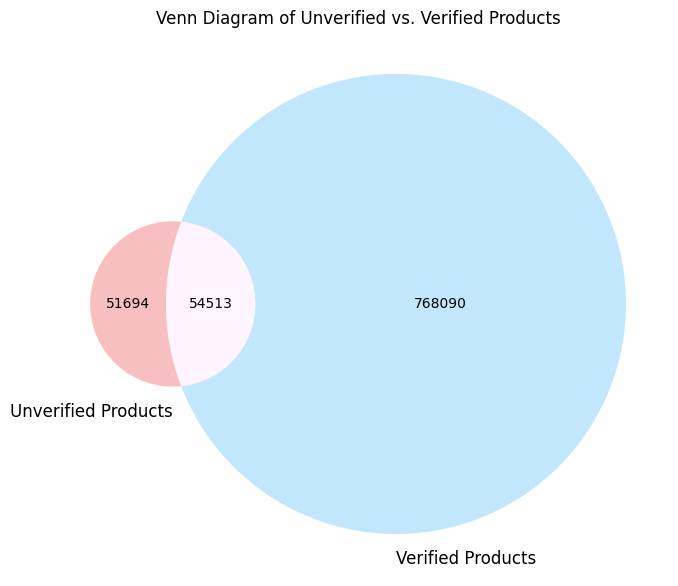

In [32]:
import matplotlib.pyplot as plt
from matplotlib_venn import venn2

# Set up the Venn diagram
plt.figure(figsize=(8, 8))
venn2(subsets=(only_unverified_count, only_verified_count, common_count),
      set_labels=('Unverified Products', 'Verified Products'),
      set_colors=('lightcoral', 'lightskyblue'),
      alpha=0.5)  # Transparency set to 50%

plt.title("Venn Diagram of Unverified vs. Verified Products")
plt.show()


In [33]:
# random pick 100 common products by using reservoir sampling algorithm

import random
from pyspark.sql import Row

k = 100

# Initialize the reservoir with the first k elements
reservoir = [row['asin'] for row in common_products.limit(k).collect()]

total_rows = common_products.count()
common_products_rdd = common_products.rdd

# Perform reservoir sampling
def reservoir_sampling(index, iterator):
    global reservoir
    # Start from k+1 since the first k elements are already in the reservoir
    offset = k
    data_list = list(iterator)
    for element in data_list:
        current_position = index + offset
        random_index = random.randint(0, current_position)
        if random_index < k:
            reservoir[random_index] = element['asin']
        offset += 1
    return iter([])

# Apply the reservoir sampling algorithm
common_products_rdd.mapPartitionsWithIndex(reservoir_sampling).count()  # Action to trigger the computation

reservoir_df = spark.createDataFrame([Row(asin=x) for x in reservoir], ["asin"])

reservoir_df.count()


100

In [39]:
from pyspark.sql.functions import col, avg, when

# Join reservoir_df with false_verified and verified_df on 'asin' and calculate average ratings
avg_ratings_unverified = reservoir_df.join(false_verified, "asin").groupBy("asin").agg(avg("rating").alias("avg_rating_unverified"))
avg_ratings_verified_df = reservoir_df.join(verified_df, "asin").groupBy("asin").agg(avg("rating").alias("avg_rating_verified"))

# Join the average ratings dataframes to compare
avg_ratings_joined = avg_ratings_unverified.join(avg_ratings_verified_df, "asin")

# Add columns to classify each 'asin' based on their rating comparison
avg_ratings_joined = avg_ratings_joined.withColumn(
    "rating_comparison",
    when(col("avg_rating_unverified") == col("avg_rating_verified"), "Equal")
    .otherwise("Not Equal")
)

# Count the total number of ASINs
total_asins = avg_ratings_joined.count()

# Calculate the count for each category
category_counts = avg_ratings_joined.groupBy("rating_comparison").count()

# Calculate the percentage for each category
category_percentages = category_counts.withColumn("percentage", (col("count") / total_asins) * 100)

# Show the results
category_counts.show()


+-----------------+-----+
|rating_comparison|count|
+-----------------+-----+
|        Not Equal|   90|
|            Equal|   10|
+-----------------+-----+



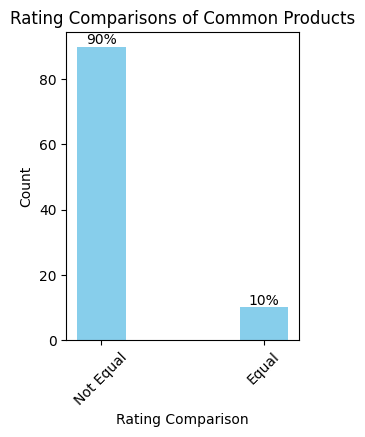

In [43]:
import matplotlib.pyplot as plt
import pandas as pd

from pyspark.sql.functions import col, avg, when

# Join reservoir_df with false_verified and verified_df on 'asin' and calculate average ratings
avg_ratings_unverified = reservoir_df.join(false_verified, "asin").groupBy("asin").agg(avg("rating").alias("avg_rating_unverified"))
avg_ratings_verified_df = reservoir_df.join(verified_df, "asin").groupBy("asin").agg(avg("rating").alias("avg_rating_verified"))

# Join the average ratings dataframes to compare
avg_ratings_joined = avg_ratings_unverified.join(avg_ratings_verified_df, "asin")

# Add columns to classify each 'asin' based on their rating comparison
avg_ratings_joined = avg_ratings_joined.withColumn(
    "rating_comparison",
    when(col("avg_rating_unverified") == col("avg_rating_verified"), "Equal")
    .otherwise("Not Equal")
)

# Count the total number of ASINs
total_asins = avg_ratings_joined.count()

# Calculate the count for each category
category_counts = avg_ratings_joined.groupBy("rating_comparison").count()

# Convert to Pandas DataFrame for plotting
category_counts_pandas = category_counts.toPandas()

# Calculate percentages for the labels
category_counts_pandas['percentage'] = (category_counts_pandas['count'] / total_asins * 100).round(0).astype(int)

# Plotting the histogram
plt.figure(figsize=(3, 4))
bars = plt.bar(category_counts_pandas['rating_comparison'], category_counts_pandas['count'], color='skyblue', width=0.3)
plt.xlabel('Rating Comparison')
plt.ylabel('Count')
plt.title('Rating Comparisons of Common Products')
plt.xticks(rotation=45)

# Adding the percentage labels on each bar
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, f'{int(yval/total_asins*100)}%', ha='center', va='bottom')

plt.show()
